In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re


os.chdir('/content/drive/MyDrive/SSCI575-final project/')

# 1 Handle the Tables

## 1.1 Squirrel

In [ ]:
ny_squirrels = pd.read_csv('2018_Central_Park_Squirrel_Census_-_Squirrel_Data_20231017.csv')
ny_squirrels.head()

,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Highlight Fur Color,...,Kuks,Quaas,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from,Other Interactions,Lat/Long
0,-73.956134,40.794082,37F-PM-1014-03,37F,PM,10142018,3,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9561344937861 40.7940823884086)
1,-73.968857,40.783783,21B-AM-1019-04,21B,AM,10192018,4,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9688574691102 40.7837825208444)
2,-73.974281,40.775534,11B-PM-1014-08,11B,PM,10142018,8,NaN,Gray,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.97428114848522 40.775533619083)
3,-73.959641,40.790313,32E-PM-1017-14,32E,PM,10172018,14,Adult,Gray,NaN,...,False,False,False,False,False,False,False,True,NaN,POINT (-73.9596413903948 40.7903128889029)
4,-73.970268,40.776213,13E-AM-1017-05,13E,AM,10172018,5,Adult,Gray,Cinnamon,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9702676472613 40.7762126854894)


In [ ]:
ny_squirrels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3023 entries, 0 to 3022
Data columns (total 31 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   X                                           3023 non-null   float64
 1   Y                                           3023 non-null   float64
 2   Unique Squirrel ID                          3023 non-null   object 
 3   Hectare                                     3023 non-null   object 
 4   Shift                                       3023 non-null   object 
 5   Date                                        3023 non-null   int64  
 6   Hectare Squirrel Number                     3023 non-null   int64  
 7   Age                                         2902 non-null   object 
 8   Primary Fur Color                           2968 non-null   object 
 9   Highlight Fur Color                         1937 non-null   object 
 10  Combination 

Most of the nulls in the table are hard to interpret and fill as they are concrete characteristics of squirrels.

In [ ]:
ny_squirrels['DayShift'] = ny_squirrels['Date'].astype('str') + ny_squirrels['Shift']
ny_squirrels['DayShift'].nunique()

22

In [ ]:
sorted(ny_squirrels['DayShift'].unique())

['10062018AM',
 '10062018PM',
 '10072018AM',
 '10072018PM',
 '10082018AM',
 '10082018PM',
 '10102018AM',
 '10102018PM',
 '10122018AM',
 '10122018PM',
 '10132018AM',
 '10132018PM',
 '10142018AM',
 '10142018PM',
 '10172018AM',
 '10172018PM',
 '10182018AM',
 '10182018PM',
 '10192018AM',
 '10192018PM',
 '10202018AM',
 '10202018PM']

According to the table, there are 22 time intervals with a length of half a day. Then check the locations of squirrel activities.

In [ ]:
ny_squirrels['Hectare'].nunique()

339

There are 339 census tracts (boxes that artificially divide the park into even small squares) in which there are squirrels observed.

Then convert the date to a regular format. There is AMand PM records, so assign dates specifications of hours: 12:00:00 for AM and 23:59:59 for PM. Thus we get the exact half-day's intervals and assign them time points.

For instance, the date time '2018/10/10 AM' will be converted to '2018/10/10 11:59:59'.

The records cover from October 6 to 20 in 2018.

In [ ]:
ny_squirrels['date'] = ny_squirrels['Date'].astype(str).apply(lambda d: d[-4:] + '/' + d[:2] + '/' + d[2:-4]) +\
                       ny_squirrels['Shift'].apply(lambda s: ' 11:59:59' if s == 'AM' else ' 23:59:59')
ny_squirrels['date'].sort_values()

2810    2018/10/06 11:59:59
1329    2018/10/06 11:59:59
1086    2018/10/06 11:59:59
2288    2018/10/06 11:59:59
2279    2018/10/06 11:59:59
               ...         
633     2018/10/20 23:59:59
69      2018/10/20 23:59:59
354     2018/10/20 23:59:59
215     2018/10/20 23:59:59
1367    2018/10/20 23:59:59
Name: date, Length: 3023, dtype: object

Further check the unrecorded intervals. This means we try to find those consecutive time points between which there are more than 12 hours.

In [ ]:
all_timepoints = pd.to_datetime(pd.Series(ny_squirrels['date'].unique()).sort_values())
all_timepoints.diff()

10               NaT
6    0 days 12:00:00
12   0 days 12:00:00
8    0 days 12:00:00
5    0 days 12:00:00
14   0 days 12:00:00
4    1 days 12:00:00
9    0 days 12:00:00
21   1 days 12:00:00
15   0 days 12:00:00
13   0 days 12:00:00
7    0 days 12:00:00
17   0 days 12:00:00
0    0 days 12:00:00
3    2 days 12:00:00
2    0 days 12:00:00
19   0 days 12:00:00
11   0 days 12:00:00
1    0 days 12:00:00
18   0 days 12:00:00
20   0 days 12:00:00
16   0 days 12:00:00
dtype: timedelta64[ns]

In [ ]:
for i, j in zip(all_timepoints.diff()[all_timepoints.diff() > pd.Timedelta(hours = 12)], all_timepoints[all_timepoints.diff() > pd.Timedelta(hours = 12)]):
  print(j - i, '  ', j)

2018-10-08 23:59:59    2018-10-10 11:59:59
2018-10-10 23:59:59    2018-10-12 11:59:59
2018-10-14 23:59:59    2018-10-17 11:59:59


## 1.2 Census Grids

The central park is divided into losts of even squares with a size of **one hectare, i.e. 100 meters * 100 meters**. First, import the table of these tracts.

In [ ]:
df_grids = pd.read_csv('2018_Central_Park_Squirrel_Census_-_Hectare_Grid_20231103.csv')
df_grids

,the_geom,id,xmin,xmax,ymin,ymax
0,MULTIPOLYGON (((-73.95816284567162 40.80102139...,82,"989,030.73113","989,358.81512","231,243.27134","231,571.35533"
1,MULTIPOLYGON (((-73.95712568765475 40.80058581...,83,"989,358.81512","989,686.89911","231,243.27134","231,571.35533"
2,MULTIPOLYGON (((-73.95608854321127 40.80015023...,84,"989,686.89911","990,014.9831","231,243.27134","231,571.35533"
3,MULTIPOLYGON (((-73.9550514123412 40.799714636...,85,"990,014.9831","990,343.06709","231,243.27134","231,571.35533"
4,MULTIPOLYGON (((-73.9540142950446 40.799279030...,86,"990,343.06709","990,671.15108","231,243.27134","231,571.35533"
...,...,...,...,...,...,...
373,MULTIPOLYGON (((-73.97750517097374 40.76696330...,865,"990,343.06709","990,671.15108","217,791.82775","218,119.91174"
374,MULTIPOLYGON (((-73.97646841686014 40.76652789...,866,"990,671.15108","990,999.23507","217,791.82775","218,119.91174"
375,MULTIPOLYGON (((-73.97543167630229 40.76609247...,867,"990,999.23507","991,327.31906","217,791.82775","218,119.91174"
376,MULTIPOLYGON (((-73.97439494930025 40.76565705...,868,"991,327.31906","991,655.40305","217,791.82775","218,119.91174"


Convert it to a GeoDataFrame and visualize them. When specifying its geometry, use the package *shapely*. Also, add a basemap by the package *contextily*.

In [ ]:
%%capture
!pip install contextily
import contextily as ctx

from shapely.geometry import Polygon, Point
from shapely import wkt

In [ ]:
try:
  df_grids['the_geom'] = df_grids['the_geom'].apply(wkt.loads)
except:
  pass
census_grids = gpd.GeoDataFrame(df_grids, geometry = 'the_geom')
census_grids.crs = 'EPSG:4326'

In [ ]:
len(census_grids)

378

In [ ]:
fig1, ax1 = plt.subplots(figsize = (25, 12))
census_grids.plot(ax = ax1, linewidth = .8, color = 'purple', edgecolor = 'navy', alpha = .3)
ctx.add_basemap(ax1, crs = census_grids.crs, source = ctx.providers.OpenStreetMap.Mapnik)
plt.title('The Map of the Census Grids')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
len(census_grids)

378

There are 378 grids in total, in 339 of which there are squirrels observed.

## 1.3 Features of Space-time Observations

In order to construct the summary of the squirrels activities in these grids, we assign all the time intervals to the grids to identify the observations in the time and space. We already found voids in the time. Then check the number of records in each time interval (half a day) to identify if there are voids in the space.

Observations are point data of the information of the observed squirrels, including numbers, colors, behaviors, etc. Attribute points of observations by assigning them to the grids they fall into.

In [ ]:
ny_squirrels

,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Highlight Fur Color,...,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from,Other Interactions,Lat/Long,DayShift,date
0,-73.956134,40.794082,37F-PM-1014-03,37F,PM,10142018,3,NaN,NaN,NaN,...,False,False,False,False,False,False,NaN,POINT (-73.9561344937861 40.7940823884086),10142018PM,2018/10/14 23:59:59
1,-73.968857,40.783783,21B-AM-1019-04,21B,AM,10192018,4,NaN,NaN,NaN,...,False,False,False,False,False,False,NaN,POINT (-73.9688574691102 40.7837825208444),10192018AM,2018/10/19 11:59:59
2,-73.974281,40.775534,11B-PM-1014-08,11B,PM,10142018,8,NaN,Gray,NaN,...,False,False,False,False,False,False,NaN,POINT (-73.97428114848522 40.775533619083),10142018PM,2018/10/14 23:59:59
3,-73.959641,40.790313,32E-PM-1017-14,32E,PM,10172018,14,Adult,Gray,NaN,...,False,False,False,False,False,True,NaN,POINT (-73.9596413903948 40.7903128889029),10172018PM,2018/10/17 23:59:59
4,-73.970268,40.776213,13E-AM-1017-05,13E,AM,10172018,5,Adult,Gray,Cinnamon,...,False,False,False,False,False,False,NaN,POINT (-73.9702676472613 40.7762126854894),10172018AM,2018/10/17 11:59:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3018,-73.963943,40.790868,30B-AM-1007-04,30B,AM,10072018,4,Adult,Gray,NaN,...,False,False,False,False,False,True,NaN,POINT (-73.9639431360458 40.7908677445466),10072018AM,2018/10/07 11:59:59
3019,-73.970402,40.782560,19A-PM-1013-05,19A,PM,10132018,5,Adult,Gray,White,...,False,False,False,False,True,False,NaN,POINT (-73.9704015859639 40.7825600069973),10132018PM,2018/10/13 23:59:59
3020,-73.966587,40.783678,22D-PM-1012-07,22D,PM,10122018,7,Adult,Gray,"Black, Cinnamon, White",...,False,False,False,False,True,False,NaN,POINT (-73.9665871993517 40.7836775064883),10122018PM,2018/10/12 23:59:59
3021,-73.963994,40.789915,29B-PM-1010-02,29B,PM,10102018,2,NaN,Gray,"Cinnamon, White",...,False,False,False,False,True,False,NaN,POINT (-73.9639941227864 40.7899152327912),10102018PM,2018/10/10 23:59:59


In [ ]:
point_squirrels = gpd.GeoDataFrame(ny_squirrels,
                                   geometry = [Point(xy) for xy in zip(ny_squirrels['X'], ny_squirrels['Y'])],
                                   crs = 'EPSG: 4236')

In [ ]:
df_observation  = gpd.sjoin(point_squirrels, census_grids, how = 'left', op = 'intersects')
df_observation

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-19-c58ca1f2e9e0>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG: 4236
Right CRS: EPSG:4326

  df_observation  = gpd.sjoin(point_squirrels, census_grids, how = 'left', op = 'intersects')


,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Highlight Fur Color,...,Lat/Long,DayShift,date,geometry,index_right,id,xmin,xmax,ymin,ymax
0,-73.956134,40.794082,37F-PM-1014-03,37F,PM,10142018,3,NaN,NaN,NaN,...,POINT (-73.9561344937861 40.7940823884086),10142018PM,2018/10/14 23:59:59,POINT (-73.95613 40.79408),50,182,"990,671.15108","990,999.23507","229,602.85139","229,930.93538"
1,-73.968857,40.783783,21B-AM-1019-04,21B,AM,10192018,4,NaN,NaN,NaN,...,POINT (-73.9688574691102 40.7837825208444),10192018AM,2018/10/19 11:59:59,POINT (-73.96886 40.78378),190,482,"989,358.81512","989,686.89911","224,353.50755","224,681.59154"
2,-73.974281,40.775534,11B-PM-1014-08,11B,PM,10142018,8,NaN,Gray,NaN,...,POINT (-73.97428114848522 40.775533619083),10142018PM,2018/10/14 23:59:59,POINT (-73.97428 40.77553),280,672,"989,358.81512","989,686.89911","221,072.66765","221,400.75164"
3,-73.959641,40.790313,32E-PM-1017-14,32E,PM,10172018,14,Adult,Gray,NaN,...,POINT (-73.9596413903948 40.7903128889029),10172018PM,2018/10/17 23:59:59,POINT (-73.95964 40.79031),103,295,"990,343.06709","990,671.15108","227,634.34745","227,962.43144"
4,-73.970268,40.776213,13E-AM-1017-05,13E,AM,10172018,5,Adult,Gray,Cinnamon,...,POINT (-73.9702676472613 40.7762126854894),10172018AM,2018/10/17 11:59:59,POINT (-73.97027 40.77621),265,637,"990,343.06709","990,671.15108","221,728.83563","222,056.91962"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3018,-73.963943,40.790868,30B-AM-1007-04,30B,AM,10072018,4,Adult,Gray,NaN,...,POINT (-73.9639431360458 40.7908677445466),10072018AM,2018/10/07 11:59:59,POINT (-73.96394 40.79087),109,311,"989,358.81512","989,686.89911","227,306.26346","227,634.34745"
3019,-73.970402,40.782560,19A-PM-1013-05,19A,PM,10132018,5,Adult,Gray,White,...,POINT (-73.9704015859639 40.7825600069973),10132018PM,2018/10/13 23:59:59,POINT (-73.97040 40.78256),198,500,"989,030.73113","989,358.81512","224,025.42356","224,353.50755"
3020,-73.966587,40.783678,22D-PM-1012-07,22D,PM,10122018,7,Adult,Gray,"Black, Cinnamon, White",...,POINT (-73.9665871993517 40.7836775064883),10122018PM,2018/10/12 23:59:59,POINT (-73.96659 40.78368),183,465,"990,014.9831","990,343.06709","224,681.59154","225,009.67553"
3021,-73.963994,40.789915,29B-PM-1010-02,29B,PM,10102018,2,NaN,Gray,"Cinnamon, White",...,POINT (-73.9639941227864 40.7899152327912),10102018PM,2018/10/10 23:59:59,POINT (-73.96399 40.78992),118,330,"989,358.81512","989,686.89911","226,978.17947","227,306.26346"


In [ ]:
df_observation.groupby('date').size()

date
2018/10/06 11:59:59    163
2018/10/06 23:59:59    174
2018/10/07 11:59:59    208
2018/10/07 23:59:59    197
2018/10/08 11:59:59    165
2018/10/08 23:59:59    120
2018/10/10 11:59:59    189
2018/10/10 23:59:59    146
2018/10/12 11:59:59     77
2018/10/12 23:59:59    141
2018/10/13 11:59:59    110
2018/10/13 23:59:59    324
2018/10/14 11:59:59    169
2018/10/14 23:59:59    199
2018/10/17 11:59:59    110
2018/10/17 23:59:59    106
2018/10/18 11:59:59     75
2018/10/18 23:59:59    125
2018/10/19 11:59:59     63
2018/10/19 23:59:59     95
2018/10/20 11:59:59     18
2018/10/20 23:59:59     49
dtype: int64

In [ ]:
df_observation.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3023 entries, 0 to 3022
Data columns (total 40 columns):
 #   Column                                      Non-Null Count  Dtype   
---  ------                                      --------------  -----   
 0   X                                           3023 non-null   float64 
 1   Y                                           3023 non-null   float64 
 2   Unique Squirrel ID                          3023 non-null   object  
 3   Hectare                                     3023 non-null   object  
 4   Shift                                       3023 non-null   object  
 5   Date                                        3023 non-null   int64   
 6   Hectare Squirrel Number                     3023 non-null   int64   
 7   Age                                         2902 non-null   object  
 8   Primary Fur Color                           2968 non-null   object  
 9   Highlight Fur Color                         1937 non-null   object

## 1.4 Information of Census Grids

There is also a table of Census Grids' information, where there are descriptions of what happened in each grids during each observation period, like temperature and other creatures.

In [ ]:
df_grids_info = pd.read_csv('2018_Central_Park_Squirrel_Census_-_Hectare_Data_20231017.csv')
df_grids_info

,Hectare,Shift,Date,Anonymized Sighter,Sighter Observed Weather Data,Litter,Litter Notes,Other Animal Sightings,Hectare Conditions,Hectare Conditions Notes,Number of sighters,Number of Squirrels,Total Time of Sighting
0,01A,AM,10072018,1.100000e+02,"70º F, Foggy",Some,NaN,"Humans, Pigeons",Busy,NaN,1,4,22.0
1,01A,PM,10142018,1.770000e+02,"54º F, overcast",Abundant,NaN,"Humans, Pigeons",Busy,NaN,1,7,26.0
2,01B,AM,10122018,1.100000e+01,"60º F, sunny",Some,NaN,"Humans, Dogs, Pigeons, Horses",Busy,NaN,1,17,23.0
3,01B,PM,10192018,1.090000e+02,"59.8º F, Sun, Cool",Some,NaN,"Humans, Dogs, Pigeons, Sparrow, Blue jay",Busy,NaN,1,10,35.0
4,01C,PM,10132018,2.410000e+02,"55° F, Partly Cloudy",None,NaN,"Humans, Dogs, Pigeons, Birds",Busy,NaN,1,10,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,09A,AM,10132018,1.791802e+08,NaN,Some,NaN,"Humans, Dogs, Pigeons, Rats, Blue jays",Busy,NaN,3,12,20.0
696,11F,PM,10062018,1.680000e+02,NaN,Some,NaN,"Humans, Dogs, Pigeons",Busy,NaN,3,3,26.0
697,12G,PM,10072018,1.061071e+02,80º F,None,NaN,"Humans, Cat bird",Busy,NaN,3,7,29.0
698,12H,PM,10072018,1.061071e+02,79º F,None,NaN,"Humans, Sparrows",Busy,NaN,3,8,30.0


In [ ]:
df_grids_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Hectare                        700 non-null    object 
 1   Shift                          700 non-null    object 
 2   Date                           700 non-null    int64  
 3   Anonymized Sighter             700 non-null    float64
 4   Sighter Observed Weather Data  681 non-null    object 
 5   Litter                         610 non-null    object 
 6   Litter Notes                   6 non-null      object 
 7   Other Animal Sightings         668 non-null    object 
 8   Hectare Conditions             660 non-null    object 
 9   Hectare Conditions Notes       74 non-null     object 
 10  Number of sighters             700 non-null    int64  
 11  Number of Squirrels            700 non-null    int64  
 12  Total Time of Sighting         680 non-null    flo

In [ ]:
df_grids_info.describe()

,Date,Anonymized Sighter,Number of sighters,Number of Squirrels,Total Time of Sighting
count,7.000000e+02,7.000000e+02,700.000000,700.000000,680.000000
mean,1.012160e+07,7.261435e+05,1.142857,4.317143,24.907353
std,4.328731e+04,1.096542e+07,0.388891,3.559748,6.916839
min,1.006202e+07,1.000000e+00,1.000000,0.000000,1.000000
25%,1.008202e+07,8.000000e+01,1.000000,2.000000,20.000000
50%,1.012702e+07,1.550000e+02,1.000000,4.000000,24.000000
75%,1.014202e+07,2.400000e+02,1.000000,6.000000,26.000000
max,1.020202e+07,1.791802e+08,3.000000,23.000000,70.000000


Convert the time to observation intervals. The method is, give unique space-time ID to each observation, to differentiate the time and space where it is located.

In [ ]:
df_grids_info['date'] = df_grids_info['Date'].astype(str).apply(lambda d: d[-4:] + '/' + d[:2] + '/' + d[2:-4]) +\
                       df_grids_info['Shift'].apply(lambda s: ' 11:59:59' if s == 'AM' else ' 23:59:59')
df_grids_info['date']

0      2018/10/07 11:59:59
1      2018/10/14 23:59:59
2      2018/10/12 11:59:59
3      2018/10/19 23:59:59
4      2018/10/13 23:59:59
              ...         
695    2018/10/13 11:59:59
696    2018/10/06 23:59:59
697    2018/10/07 23:59:59
698    2018/10/07 23:59:59
699    2018/10/06 23:59:59
Name: date, Length: 700, dtype: object

In [ ]:
df_grids_info['ST ID'] = (df_grids_info['date'] + ' ' + df_grids_info['Hectare'])
df_observation['ST ID'] = (df_observation['date'] + ' ' + df_observation['Hectare'])

df_grids_info['ST ID']

0      2018/10/07 11:59:59 01A
1      2018/10/14 23:59:59 01A
2      2018/10/12 11:59:59 01B
3      2018/10/19 23:59:59 01B
4      2018/10/13 23:59:59 01C
                ...           
695    2018/10/13 11:59:59 09A
696    2018/10/06 23:59:59 11F
697    2018/10/07 23:59:59 12G
698    2018/10/07 23:59:59 12H
699    2018/10/06 23:59:59 26A
Name: ST ID, Length: 700, dtype: object

# 2 Explore the Data

Then, find the attributes that are correlated with the counts of squirrels.

First, plot the aggregate counts of squirrels by time.

There is a decrease in the number of squirrels around the park. Also, there is a peak on roughly 10.14 or 15.

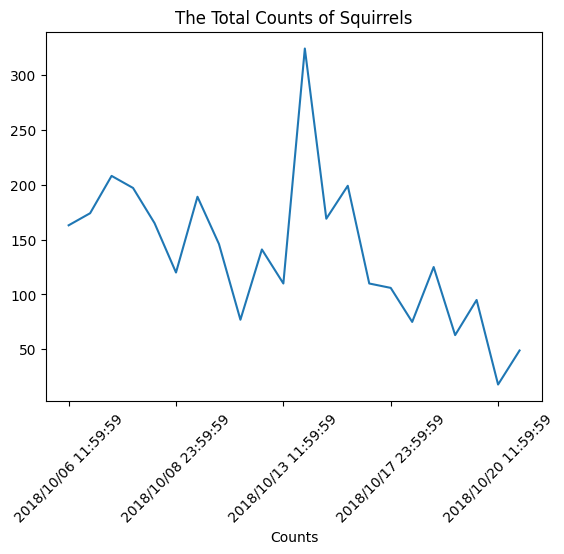

In [ ]:
df_observation.groupby('date').size().plot()
plt.xticks(rotation = 45)
plt.title('The Total Counts of Squirrels')
plt.xlabel('Counts')
plt.show()

Then check if it is associated with the temperature. In the table of census tracts' information, there are temperatures in each grids. Merge it with the observation table. Then extract temperatures from the description of weather.


In [ ]:
 df_grids_obsv = df_observation.merge(df_grids_info[['ST ID', 'Anonymized Sighter',\
                                                     'Sighter Observed Weather Data', 'Litter', 'Litter Notes',\
                                                     'Other Animal Sightings', 'Hectare Conditions',\
                                                     'Hectare Conditions Notes', 'Number of sighters', 'Number of Squirrels',\
                                                     'Total Time of Sighting']], on = 'ST ID', how = 'left').copy()
df_grids_obsv

,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Highlight Fur Color,...,Anonymized Sighter,Sighter Observed Weather Data,Litter,Litter Notes,Other Animal Sightings,Hectare Conditions,Hectare Conditions Notes,Number of sighters,Number of Squirrels,Total Time of Sighting
0,-73.956134,40.794082,37F-PM-1014-03,37F,PM,10142018,3,NaN,NaN,NaN,...,243.0,"59º F, overcast, SW 6 mph",None,NaN,Humans,Busy,NaN,1.0,3.0,24.0
1,-73.968857,40.783783,21B-AM-1019-04,21B,AM,10192018,4,NaN,NaN,NaN,...,213214.0,"Mid 40s, Clear, No Wind",Some,NaN,"Humans, Dogs, Pigeons, Birds",Calm,NaN,2.0,7.0,25.0
2,-73.974281,40.775534,11B-PM-1014-08,11B,PM,10142018,8,NaN,Gray,NaN,...,234.0,"Cool, Cloudy",Some,NaN,"Humans, Dogs, Horses",Busy,NaN,1.0,8.0,18.0
3,-73.959641,40.790313,32E-PM-1017-14,32E,PM,10172018,14,Adult,Gray,NaN,...,125.0,"61º F, cloudy",Some,NaN,"Humans, Dogs",Busy,NaN,1.0,16.0,25.0
4,-73.970268,40.776213,13E-AM-1017-05,13E,AM,10172018,5,Adult,Gray,Cinnamon,...,224.0,"52º F, sunny & brisk",Some,NaN,"Humans, Birds (non-pigeon)",Calm,NaN,1.0,13.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3018,-73.963943,40.790868,30B-AM-1007-04,30B,AM,10072018,4,Adult,Gray,NaN,...,170.0,"70º F, Overcast. Moist.",Some,NaN,"Humans, Dogs, Assorted Birds",Busy,NaN,1.0,12.0,20.0
3019,-73.970402,40.782560,19A-PM-1013-05,19A,PM,10132018,5,Adult,Gray,White,...,13.0,"~Low 50s, cold, partly cloudy, sunshine",Some,1 reusable bag,"Humans, Dogs, Sparrows, Blue Finch-like Birds,...",Busy,NaN,1.0,6.0,26.0
3020,-73.966587,40.783678,22D-PM-1012-07,22D,PM,10122018,7,Adult,Gray,"Black, Cinnamon, White",...,16.0,"61º F, sunny",None,NaN,"Humans, Pigeons, Sparrows","Calm, Busy",NaN,1.0,7.0,26.0
3021,-73.963994,40.789915,29B-PM-1010-02,29B,PM,10102018,2,NaN,Gray,"Cinnamon, White",...,65.0,"70s, Sunny, humid",None,NaN,"Humans, Dogs, Birds",Busy,NaN,1.0,5.0,25.0


In [ ]:
def convert_to_fahrenheit(temperature, unit):
    if (unit.lower() == 'c'):
        # Convert Celsius to Fahrenheit
        temperature = (float(temperature) * 9/5) + 32
    elif (unit.lower() == 'f') or (unit.lower() == 's'):
        # Already in Fahrenheit, no conversion needed
        temperature = float(temperature)
    else:
        raise ValueError("Invalid temperature unit. Supported units: 'C', 'S' or 'F'")

    return temperature

def extract_and_convert_temperature(sentence):
    # Define a regular expression pattern to match temperature and unit
    pattern = r'(\d+(\.\d+)?)\s*º\s*([CFcfsS])'

    # Find all matches in the sentence
    matches = re.findall(pattern, sentence)
    if matches:
        value, _, unit = matches[0]
        return convert_to_fahrenheit(value, unit)
    else:
        return None

In [ ]:
 df_grids_obsv.loc[df_grids_obsv['Sighter Observed Weather Data'].notnull(), 'Temperature'] =  df_grids_obsv[df_grids_obsv['Sighter Observed Weather Data'].notnull()]['Sighter Observed Weather Data'].apply(lambda d: extract_and_convert_temperature(d))

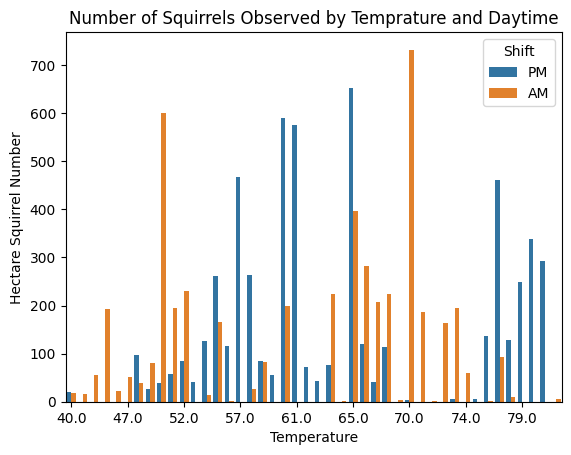

In [ ]:
temp_F_counts = df_grids_obsv.groupby(by = ['Temperature', 'Shift'])['Hectare Squirrel Number'].sum().\
                reset_index().sort_values('Shift',ascending = False)
sns.barplot(data = temp_F_counts, x = 'Temperature', y = 'Hectare Squirrel Number', hue = 'Shift')
plt.xticks(range(0, temp_F_counts['Temperature'].nunique(), 5))
plt.title('Number of Squirrels Observed by Temprature and Daytime')
plt.show()

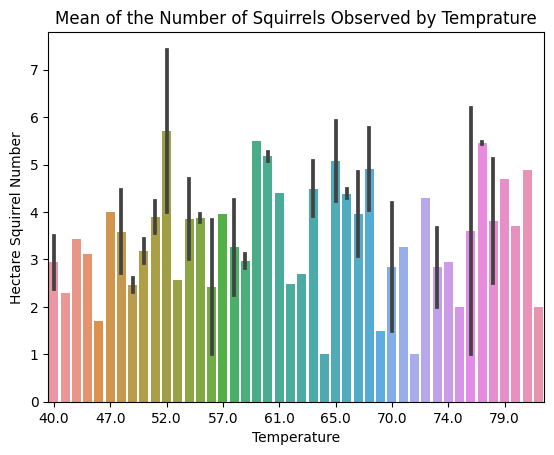

In [ ]:
temp_F_counts = df_grids_obsv.groupby(by = ['Temperature', 'Shift'])['Hectare Squirrel Number'].mean().\
                reset_index().sort_values('Shift',ascending = False)
sns.barplot(data = temp_F_counts, x = 'Temperature', y = 'Hectare Squirrel Number')
plt.xticks(range(0, temp_F_counts['Temperature'].nunique(), 5))
plt.title('Mean of the Number of Squirrels Observed by Temprature')
plt.show()

Usually, the number of squirrels does not change ignificantly by temperature,  but the distributions by day and night are obviously different.

Then, incorporate the time, check the distribution of observations.

In [ ]:
try:
    df_grids_obsv['Date'] = pd.to_datetime(df_grids_obsv['Date'].astype(str).apply(lambda d: d[-4:] + '/' + d[:2] + '/' + d[2:-4]))
except:
    df_grids_obsv['Date'] = df_grids_obsv['Date'].astype(str)

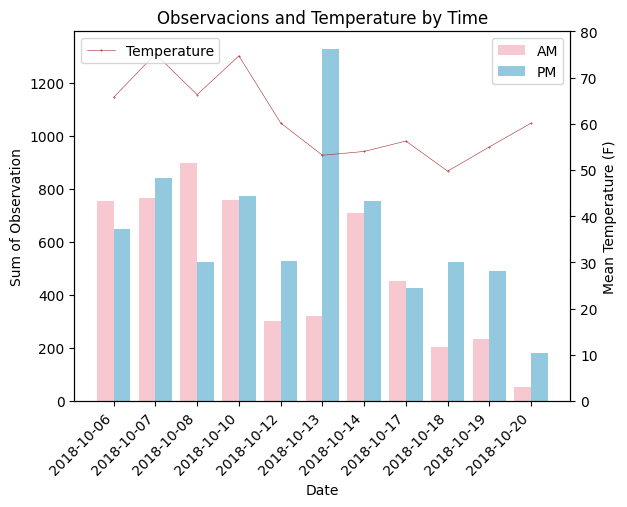

In [ ]:
temp_t_counts = df_grids_obsv.groupby(by = ['Date', 'Shift'])[['Hectare Squirrel Number', 'Temperature']].agg({'Hectare Squirrel Number': 'sum', 'Temperature': 'mean'}).reset_index()
temp_t_counts['Date'] = temp_t_counts['Date'].astype(str)
fig, ax1 = plt.subplots()
sns.barplot(data = temp_t_counts, x = 'Date', y = 'Hectare Squirrel Number', ax = ax1, hue = 'Shift', palette = ['pink', 'skyblue'])
ax1.set(xlabel = 'Date', ylabel = 'Sum of Observation', title = 'Observacions and Temperature by Time')
plt.xticks(rotation = 45, ha = 'right')
ax1.legend(loc = 'upper right')

temp_daily_temp = df_grids_obsv.groupby('Date')['Temperature'].mean().reset_index()
temp_daily_temp['Date'] = temp_daily_temp['Date'].astype(str)
ax2 = ax1.twinx()
ax2.plot(temp_daily_temp['Date'], temp_daily_temp['Temperature'],
        color = 'brown', marker = 'o', markersize = .4,
         linewidth = .4, label = 'Temperature')
ax2.set(ylabel = 'Mean Temperature (F)')
ax2.set_ylim(0, 80)
ax2.legend(loc = 'upper left')
#plt.legend()
plt.show()

Then check the distribution of temperature on different grids.

In [ ]:
fig1, ax1 = plt.subplots(figsize = (25, 12))
census_grids.plot(ax = ax1, linewidth = .8, color = 'purple', edgecolor = 'navy', alpha = .3)
ctx.add_basemap(ax1, crs = census_grids.crs, source = ctx.providers.OpenStreetMap.Mapnik)
plt.title('The Map of the Census Grids')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
census_grids

,the_geom,id,xmin,xmax,ymin,ymax
0,"MULTIPOLYGON (((-73.95816 40.80102, -73.95713 ...",82,"989,030.73113","989,358.81512","231,243.27134","231,571.35533"
1,"MULTIPOLYGON (((-73.95713 40.80059, -73.95609 ...",83,"989,358.81512","989,686.89911","231,243.27134","231,571.35533"
2,"MULTIPOLYGON (((-73.95609 40.80015, -73.95505 ...",84,"989,686.89911","990,014.9831","231,243.27134","231,571.35533"
3,"MULTIPOLYGON (((-73.95505 40.79971, -73.95401 ...",85,"990,014.9831","990,343.06709","231,243.27134","231,571.35533"
4,"MULTIPOLYGON (((-73.95401 40.79928, -73.95298 ...",86,"990,343.06709","990,671.15108","231,243.27134","231,571.35533"
...,...,...,...,...,...,...
373,"MULTIPOLYGON (((-73.97751 40.76696, -73.97647 ...",865,"990,343.06709","990,671.15108","217,791.82775","218,119.91174"
374,"MULTIPOLYGON (((-73.97647 40.76653, -73.97543 ...",866,"990,671.15108","990,999.23507","217,791.82775","218,119.91174"
375,"MULTIPOLYGON (((-73.97543 40.76609, -73.97439 ...",867,"990,999.23507","991,327.31906","217,791.82775","218,119.91174"
376,"MULTIPOLYGON (((-73.97439 40.76566, -73.97336 ...",868,"991,327.31906","991,655.40305","217,791.82775","218,119.91174"


In [ ]:
df_grids_obsv

,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Highlight Fur Color,...,Sighter Observed Weather Data,Litter,Litter Notes,Other Animal Sightings,Hectare Conditions,Hectare Conditions Notes,Number of sighters,Number of Squirrels,Total Time of Sighting,Temperature
0,-73.956134,40.794082,37F-PM-1014-03,37F,PM,2018-10-14,3,NaN,NaN,NaN,...,"59º F, overcast, SW 6 mph",None,NaN,Humans,Busy,NaN,1.0,3.0,24.0,59.0
1,-73.968857,40.783783,21B-AM-1019-04,21B,AM,2018-10-19,4,NaN,NaN,NaN,...,"Mid 40s, Clear, No Wind",Some,NaN,"Humans, Dogs, Pigeons, Birds",Calm,NaN,2.0,7.0,25.0,NaN
2,-73.974281,40.775534,11B-PM-1014-08,11B,PM,2018-10-14,8,NaN,Gray,NaN,...,"Cool, Cloudy",Some,NaN,"Humans, Dogs, Horses",Busy,NaN,1.0,8.0,18.0,NaN
3,-73.959641,40.790313,32E-PM-1017-14,32E,PM,2018-10-17,14,Adult,Gray,NaN,...,"61º F, cloudy",Some,NaN,"Humans, Dogs",Busy,NaN,1.0,16.0,25.0,61.0
4,-73.970268,40.776213,13E-AM-1017-05,13E,AM,2018-10-17,5,Adult,Gray,Cinnamon,...,"52º F, sunny & brisk",Some,NaN,"Humans, Birds (non-pigeon)",Calm,NaN,1.0,13.0,50.0,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3018,-73.963943,40.790868,30B-AM-1007-04,30B,AM,2018-10-07,4,Adult,Gray,NaN,...,"70º F, Overcast. Moist.",Some,NaN,"Humans, Dogs, Assorted Birds",Busy,NaN,1.0,12.0,20.0,70.0
3019,-73.970402,40.782560,19A-PM-1013-05,19A,PM,2018-10-13,5,Adult,Gray,White,...,"~Low 50s, cold, partly cloudy, sunshine",Some,1 reusable bag,"Humans, Dogs, Sparrows, Blue Finch-like Birds,...",Busy,NaN,1.0,6.0,26.0,NaN
3020,-73.966587,40.783678,22D-PM-1012-07,22D,PM,2018-10-12,7,Adult,Gray,"Black, Cinnamon, White",...,"61º F, sunny",None,NaN,"Humans, Pigeons, Sparrows","Calm, Busy",NaN,1.0,7.0,26.0,61.0
3021,-73.963994,40.789915,29B-PM-1010-02,29B,PM,2018-10-10,2,NaN,Gray,"Cinnamon, White",...,"70s, Sunny, humid",None,NaN,"Humans, Dogs, Birds",Busy,NaN,1.0,5.0,25.0,NaN


## EDA on animals

In [ ]:
def animal_count(df):
    count_dict = {}
    for index, row in df.iterrows():
        if row['Other Animal Sightings'] == '':
            continue
        else:
            animals = row['Other Animal Sightings'].split(', ')
            for animal in animals:
                if animal not in count_dict:
                    count_dict[animal] = 1
                else:
                    count_dict[animal] += 1
    my_dict = {'apple': 5, 'banana': 2, 'orange': 8, 'grape': 1}

    # 按照键（字母顺序）排序
    sorted_count_alphabet = pd.Series(dict(sorted(count_dict.items())))

    # 按照值排序
    sorted_count_values = pd.Series(dict(sorted(count_dict.items(), key=lambda item: item[1], reverse=True)))

    return sorted_count_alphabet, sorted_count_values

df_grids_info['Other Animal Sightings'].fillna('', inplace=True)
sorted_count_alphabet, sorted_count_values = animal_count(df_grids_info)
sorted_count_alphabet

 Robins. Blue jays              1
American Robin                  1
American robins                 1
Assorted Birds                  1
Bee                             1
                               ..
not sure what kind of birds)    1
other Birds                     2
other Song birds                1
starling                        1
unknown bird                    1
Length: 184, dtype: int64

In [ ]:
sorted_count_values[:30]

Humans         630
Dogs           523
Pigeons        119
Birds           78
Sparrows        46
Small birds     30
Hawks           26
Ducks           25
Robins          25
Chipmunk        18
Chipmunks       17
Horses          13
Blue jay        12
Rat             10
Blue jays       10
Sparrow          9
Geese            9
Cats             8
Robin            7
Rats             7
Chickadees       6
Mice             5
Woodpecker       5
Song birds       5
Cardinal         4
Other birds      4
Finches          4
Crows            4
Falcons          4
Starlings        3
dtype: int64

So, based on the results above, we can create some new variables for future model building: dogs, birds

In [ ]:
def create_animal_variables(df):
    df['Dog'] = 0 # 0 means not appearing, 1 means appearing
    df['Bird'] = 0
    df_temp = df.copy() # to avoid changing the original dataframe
    df_temp['Other Animal Sightings'].fillna('', inplace=True)
    # fill the missing values with an empty string
    for index, row in df_temp.iterrows():
        if row['Other Animal Sightings'] == '':
            continue
        else:
            animals = row['Other Animal Sightings']
            birds = ['pigeons', 'bird', 'robin', 'sparrow', 'woodpecker', 'jay']
            if 'dog' in animals.lower():
                df.at[index, 'Dog'] = 1
            for bird in birds:
                if bird in animals.lower():
                    df.at[index, 'Bird'] = 1

create_animal_variables(df_grids_info)

In [ ]:
df_grids_info

,Hectare,Shift,Date,Anonymized Sighter,Sighter Observed Weather Data,Litter,Litter Notes,Other Animal Sightings,Hectare Conditions,Hectare Conditions Notes,Number of sighters,Number of Squirrels,Total Time of Sighting,date,ST ID,Dog,Bird
0,01A,AM,10072018,1.100000e+02,"70º F, Foggy",Some,NaN,"Humans, Pigeons",Busy,NaN,1,4,22.0,2018/10/07 11:59:59,2018/10/07 11:59:59 01A,0,1
1,01A,PM,10142018,1.770000e+02,"54º F, overcast",Abundant,NaN,"Humans, Pigeons",Busy,NaN,1,7,26.0,2018/10/14 23:59:59,2018/10/14 23:59:59 01A,0,1
2,01B,AM,10122018,1.100000e+01,"60º F, sunny",Some,NaN,"Humans, Dogs, Pigeons, Horses",Busy,NaN,1,17,23.0,2018/10/12 11:59:59,2018/10/12 11:59:59 01B,1,1
3,01B,PM,10192018,1.090000e+02,"59.8º F, Sun, Cool",Some,NaN,"Humans, Dogs, Pigeons, Sparrow, Blue jay",Busy,NaN,1,10,35.0,2018/10/19 23:59:59,2018/10/19 23:59:59 01B,1,1
4,01C,PM,10132018,2.410000e+02,"55° F, Partly Cloudy",None,NaN,"Humans, Dogs, Pigeons, Birds",Busy,NaN,1,10,25.0,2018/10/13 23:59:59,2018/10/13 23:59:59 01C,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,09A,AM,10132018,1.791802e+08,NaN,Some,NaN,"Humans, Dogs, Pigeons, Rats, Blue jays",Busy,NaN,3,12,20.0,2018/10/13 11:59:59,2018/10/13 11:59:59 09A,1,1
696,11F,PM,10062018,1.680000e+02,NaN,Some,NaN,"Humans, Dogs, Pigeons",Busy,NaN,3,3,26.0,2018/10/06 23:59:59,2018/10/06 23:59:59 11F,1,1
697,12G,PM,10072018,1.061071e+02,80º F,None,NaN,"Humans, Cat bird",Busy,NaN,3,7,29.0,2018/10/07 23:59:59,2018/10/07 23:59:59 12G,0,1
698,12H,PM,10072018,1.061071e+02,79º F,None,NaN,"Humans, Sparrows",Busy,NaN,3,8,30.0,2018/10/07 23:59:59,2018/10/07 23:59:59 12H,0,1
